# Find Bubble Nucleation Sites

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import groupby, cycle
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

splitdata  [0 5]
lenLat =  2795.084971874737
dx, dk, spec  0.6823937919616058 0.0022479407139330324 2049
dtout/dt =  16.0
light_cone =  2
tcheck = 7
threhsolds:  [4.454971420635487, 4.556538858776825, 4.658106296918165]


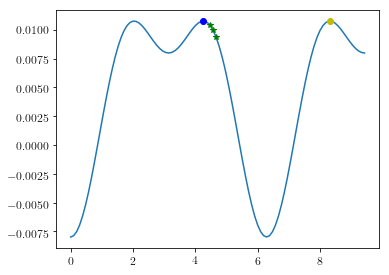

In [3]:
nTime = 256
nLat = 4096
lSim = 0
nSims = 5
step = 5
splitdata = np.arange(lSim, nSims+1, step); print('splitdata ', splitdata)

filter_size = 10.
temp = 3#2.5
phi0 = 2.5*np.pi
lamb = 1.5

nu = 2.*10**(-3)
m2eff = 4.*nu*(-1+lamb**2.)
lenLat = 250. / np.sqrt(4. * nu); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
tcheck = int(1./np.sqrt(m2eff)/dtout); print('tcheck =', tcheck)

#V = lambda phi, lamb: 4*nu*lamb/4.*( phi**2. - m2eff / lamb)**2.
V = lambda phi, lamb: ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
dV = lambda phi, lamb: ( np.sin(phi) + 0.5 * lamb**2 * np.sin(2*phi) ) * 4 * nu

far_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[2*np.pi, 3*np.pi], method='bounded')
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[np.pi, 2*np.pi], method='bounded')
#left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[0, np.pi], method='bounded')
#phi_upper_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 5)[0]; print(phi_upper_bound)
#phi_lower_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 1)[0]; print(phi_lower_bound)

list_multiplier = [0.1, 0.15, 0.2]
list_threshold= [right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier for multiplier in list_multiplier]; print('threhsolds: ', list_threshold)

plt.plot(np.linspace(0, 3*np.pi, 100), V(np.linspace(0, 3*np.pi, 100), lamb))
#plt.plot(phi_upper_bound, V(phi_upper_bound, lamb), 'ro', phi_lower_bound, V(phi_lower_bound, lamb), 'go', left_phi_at_V_max.x, V(left_phi_at_V_max.x, lamb), 'ko')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x, lamb), 'bo', far_right_phi_at_V_max.x, V(far_right_phi_at_V_max.x, lamb), 'yo')
plt.plot(list_threshold, V(list_threshold, lamb), 'g*')

In [4]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/bubbles_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(temp)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)
bubbles_file = lambda phi, lam, tem, minsim, maxsim: pickle_file+'bubbles_from_sim'+str(minsim)+'_up_to'+str(maxsim-1)+sim_suffix(phi, lam, tem)+'.npy'
posDataFile = lambda phi, lam, tem, minsim, maxsim, mltpl, sigma: pickle_file+'positiveTargets_sims'+str(minsim)+'_to'+str(maxsim-1)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'
negDataFile = lambda phi, lam, tem, minsim, maxsim, mltpl, sigma: pickle_file+'negativeTargets_sims'+str(minsim)+'_to'+str(maxsim-1)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'

In [5]:
Filter = lambda sigma: np.exp(-0.5* (np.fft.fftfreq(nLat, dx)*2*np.pi*dx*sigma)**2.)
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma)).real
list_thresh = lambda temp, sigma: np.arange(1, 500)/100*sigma0_th(temp, sigma)
round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def weave(list1,list2):
    lijst = []
    i = 0
    while i < len(list1):
        lijst.append(list1[i])
        lijst.append(list2[i]) 
        i += 1
    return lijst

def plot_real_space_data(realisation):
    T, N = np.shape(realisation)
    fig, ax = plt.subplots(1, 1, figsize = (10,5))
    im0 = plt.imshow(realisation, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax); clb.set_label(r'$\phi(x)$'); ax.set(xlabel = r'$x$', ylabel = r'$t$')
    plt.show()
    return

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def identify_bubble_sites(simulation, bubble_thr):
    nvals, new_vals = 0, 0
    vals, times = [], []
    for t in range(nTime - tcheck):
        # find new peaks in field and check if they are good bubble candidates
        peaks_new = find_peak_positions(simulation[t], bubble_thr)
        if peaks_new is not None:
            for pk in peaks_new:
                target_bounds = []
                for v in range(len(vals)):
                    # ensure new peaks are not in the light cone of the previously identified bubble nucleation sites
                    target_bounds += [i%nLat for i in range(vals[v] - np.abs(t - times[v])*light_cone, vals[v] + np.abs(t - times[v])*light_cone + 1)]
                if pk not in target_bounds:
                    vals.append(pk)
                    times.append(t)

                # discard element if future lightcone is not in tv
                if len(vals) > nvals:
                    for temp in range(times[-1], min(times[-1]+tcheck, nTime)):
                        boolShoot = False
                        deltat = temp-1 - times[-1]
                        for xemp in range(vals[-1] - deltat*light_cone, vals[-1] + deltat*light_cone + 1):
                            if not (bubble_thr < simulation[temp][xemp%nLat] < far_right_phi_at_V_max.x):#3*phi_initial):
                                vals = np.delete(np.asarray(vals), -1).tolist()
                                times = np.delete(np.asarray(times), -1).tolist()
                                boolShoot = True
                                break
                        if boolShoot:
                            break
                
#                if len(vals) > nvals:
#                    if any(simulation[pastt][vals[-1]] < 0 for pastt in range(times[-1])):
#                        vals = np.delete(np.asarray(vals), -1).tolist()
#                        times = np.delete(np.asarray(times), -1).tolist()

                if len(vals) > nvals: #crucial check here
                    bubbles = find_bubbles_at_t(simulation[t], bubble_thr)
                    nBubbles = len(bubbles)
                    bub_list, rmvlist = [], []
                    for v in range(nvals):
                        for index in range(nBubbles):
                             if (vals[v] in bubbles[index]):
                                bub_list.append(index)
                    bubbles_dup = [bubbles[index] for index in range(nBubbles) if index in set(bub_list)]
                    if bubbles_dup != []:
                        for bounds in bubbles_dup:
                            for c in range(nvals, len(vals)):
                                if (vals[c] in bounds):
                                    rmvlist.append(c)
                    if len(rmvlist) > 0:
                        vals = np.delete(np.asarray(vals), rmvlist).tolist()
                        times = np.delete(np.asarray(times), rmvlist).tolist()

                nvals = len(vals)
    return [[times[i], vals[i]] for i in range(len(vals))]

def find_bubbles_at_t(field_slice, bubble_thr):
    bubbles, mids = [], []
    vals = [x if field_slice[x] > right_phi_at_V_max.x else 0 for x in range(len(field_slice))]
    first_zero = next((i for i, x in enumerate(vals) if x == 0.), 0)
    vals = np.roll(vals, -first_zero)
    bubbles = [list(g) for k, g in groupby(vals, lambda x: x != 0) if k]
    for bubble in bubbles:
        if bubble[0] <= bubble[-1]:
            aa = np.arange(bubble[0], bubble[-1]+1)
        elif bubble[0] > bubble[-1]:
            bubble[0] = bubble[0]-nLat
            aa = np.arange(bubble[0], bubble[-1]+1)%nLat
        mids.append(aa)
    return mids

def all_bubble_sites(data, bubble_thr):
    return [identify_bubble_sites(simulation, bubble_thr) for simulation in data]

In [6]:
#alldat = np.asarray([np.reshape(np.genfromtxt(sim_location(nLat, temp, phi0, lamb, sim)), (nTime, nLat)) for sim in range(lSim, nSims)])
##alldat = np.asarray([[smoothen(slice, filter_size) for slice in simulation] for simulation in alldat])
#alldat = np.asarray([[gaussian_filter1d(slice, sigma=filter_size, mode='wrap') for slice in simulation] for simulation in alldat])
#[plot_real_space_data(simulation) for simulation in alldat]

For sims  0  to  5
29
29
29
27
27
27
Positive Bubbles: 
for multiplier =  0.1 there are 5 orange bubbles at (t, x): [[11, 2768], [12, 498], [16, 870], [21, 3381], [34, 4018]]
for multiplier =  0.15 there are 5 lightgreen bubbles at (t, x): [[13, 2767], [14, 500], [16, 870], [21, 3381], [35, 4014]]
for multiplier =  0.2 there are 5 r bubbles at (t, x): [[14, 2767], [15, 501], [17, 870], [22, 3384], [36, 4012]]


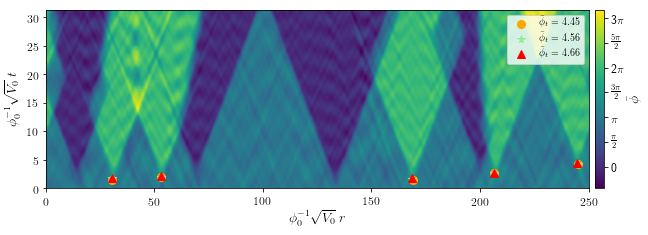

for multiplier =  0.1 there are 6 orange bubbles at (t, x): [[15, 2536], [20, 2681], [27, 3293], [52, 1920], [68, 3592], [69, 78]]
for multiplier =  0.15 there are 6 lightgreen bubbles at (t, x): [[16, 2535], [23, 2682], [28, 3292], [53, 1921], [68, 3592], [74, 80]]
for multiplier =  0.2 there are 6 r bubbles at (t, x): [[17, 2534], [25, 2683], [29, 3290], [54, 1923], [69, 3593], [76, 81]]


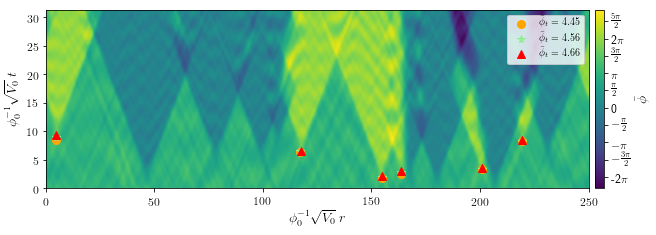

for multiplier =  0.1 there are 8 orange bubbles at (t, x): [[8, 228], [13, 55], [13, 696], [20, 3963], [22, 1309], [22, 2323], [26, 3082], [28, 789]]
for multiplier =  0.15 there are 8 lightgreen bubbles at (t, x): [[9, 230], [16, 58], [17, 702], [23, 2326], [24, 1307], [24, 3961], [29, 788], [36, 3083]]
for multiplier =  0.2 there are 8 r bubbles at (t, x): [[10, 234], [17, 63], [20, 706], [24, 2328], [25, 1306], [25, 3960], [30, 788], [41, 3089]]


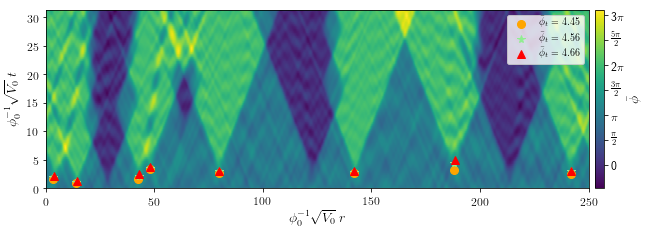

for multiplier =  0.1 there are 5 orange bubbles at (t, x): [[10, 1497], [14, 3411], [15, 507], [27, 2359], [65, 1665]]
for multiplier =  0.15 there are 5 lightgreen bubbles at (t, x): [[11, 1498], [15, 3409], [17, 509], [29, 2360], [70, 1659]]
for multiplier =  0.2 there are 5 r bubbles at (t, x): [[13, 1497], [17, 3407], [18, 510], [31, 2361], [131, 1753]]


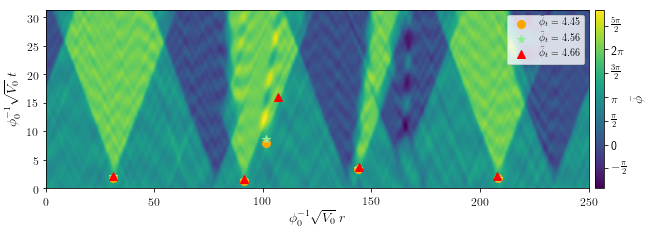

for multiplier =  0.1 there are 5 orange bubbles at (t, x): [[3, 2091], [11, 907], [36, 631], [40, 1904], [92, 132]]
for multiplier =  0.15 there are 5 lightgreen bubbles at (t, x): [[4, 2091], [12, 909], [38, 633], [41, 1902], [93, 134]]
for multiplier =  0.2 there are 5 r bubbles at (t, x): [[5, 2091], [13, 910], [39, 634], [41, 1902], [94, 135]]


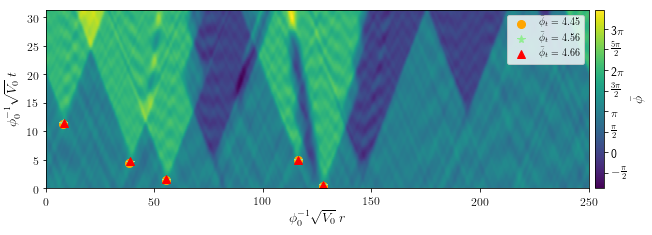

Negative Bubbles: 
for multiplier =  0.1 there are 4 orange bubbles at (t, x): [[9, 2188], [17, 248], [18, 1132], [26, 3271]]
for multiplier =  0.15 there are 4 lightgreen bubbles at (t, x): [[10, 2187], [19, 245], [19, 1131], [27, 3271]]
for multiplier =  0.2 there are 4 r bubbles at (t, x): [[11, 2186], [20, 244], [20, 1130], [28, 3271]]


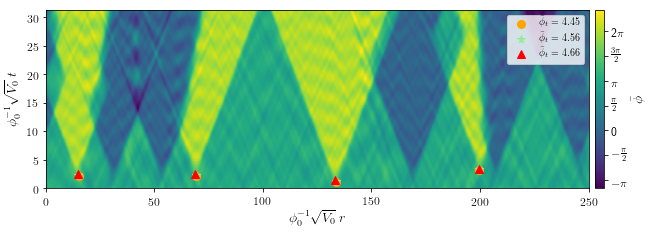

for multiplier =  0.1 there are 8 orange bubbles at (t, x): [[5, 3385], [8, 2943], [14, 2748], [15, 761], [37, 1280], [46, 1632], [47, 3787], [67, 1741]]
for multiplier =  0.15 there are 8 lightgreen bubbles at (t, x): [[6, 3385], [9, 2945], [15, 2747], [16, 762], [42, 1281], [48, 1630], [48, 3786], [68, 1742]]
for multiplier =  0.2 there are 8 r bubbles at (t, x): [[7, 3386], [10, 2946], [16, 2746], [18, 762], [44, 1280], [49, 1628], [49, 3785], [69, 1743]]


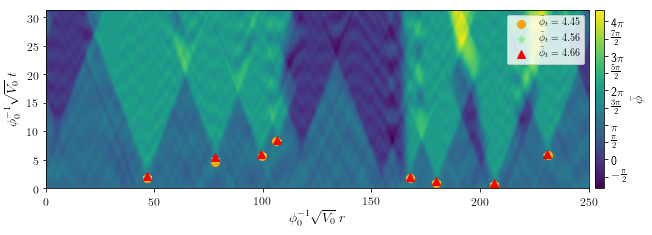

for multiplier =  0.1 there are 4 orange bubbles at (t, x): [[5, 469], [12, 3495], [19, 2003], [88, 1036]]
for multiplier =  0.15 there are 4 lightgreen bubbles at (t, x): [[6, 467], [14, 3496], [21, 2004], [93, 1038]]
for multiplier =  0.2 there are 4 r bubbles at (t, x): [[7, 466], [16, 3496], [22, 2004], [94, 1040]]


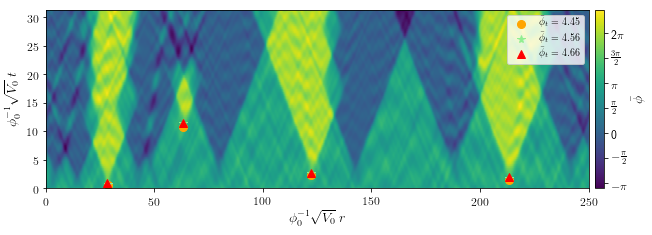

for multiplier =  0.1 there are 5 orange bubbles at (t, x): [[11, 1271], [13, 2269], [13, 3830], [41, 2650], [55, 2763]]
for multiplier =  0.15 there are 5 lightgreen bubbles at (t, x): [[12, 1271], [13, 2269], [15, 3829], [43, 2647], [57, 2761]]
for multiplier =  0.2 there are 5 r bubbles at (t, x): [[13, 1272], [14, 2268], [16, 3830], [44, 2646], [58, 2760]]


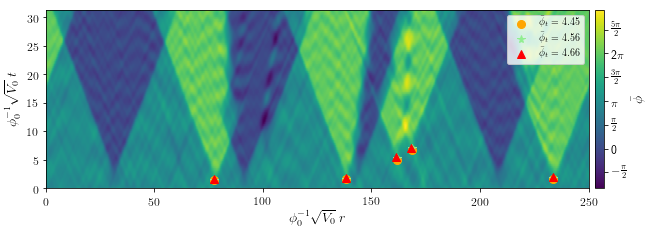

for multiplier =  0.1 there are 6 orange bubbles at (t, x): [[17, 2021], [22, 2398], [39, 1279], [103, 3174], [114, 1459], [225, 3775]]
for multiplier =  0.15 there are 6 lightgreen bubbles at (t, x): [[18, 2022], [23, 2400], [40, 1276], [103, 3174], [116, 1458], [227, 3773]]
for multiplier =  0.2 there are 6 r bubbles at (t, x): [[20, 2023], [25, 2402], [41, 1273], [104, 3174], [118, 1458], [229, 3772]]


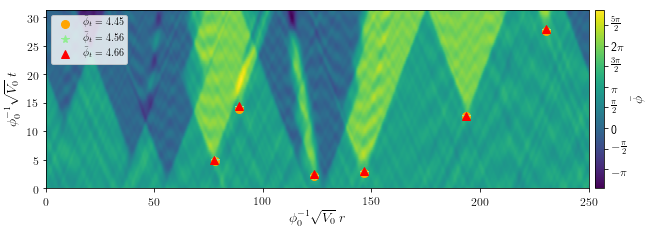

In [8]:
for minSim, maxSim in zip(splitdata, splitdata[1:]):
    all_data = np.asarray([np.reshape(np.genfromtxt(sim_location(nLat, temp, phi0, lamb, sim)), (nTime, nLat)) for sim in range(minSim, maxSim)])
    data_pos = np.asarray([[gaussian_filter1d(slice, sigma=filter_size, mode='wrap') for slice in simulation] for simulation in all_data])
    data_neg = np.asarray([[2*phi_initial - np.asarray(j) for j in i] for i in data_pos])
    print('For sims ', minSim, ' to ', maxSim)

    targets_pos = [all_bubble_sites(data_pos, threshold) for threshold in list_threshold]
    targets_neg = [all_bubble_sites(data_neg, threshold) for threshold in list_threshold]

    for sim in range(len(targets_pos[0])):
        for i in reversed(range(len(targets_pos[0][sim]))):
            if targets_pos[0][sim][i] in targets_pos[1][sim] and targets_pos[0][sim][i] in targets_pos[2][sim]:
                del targets_pos[1][sim][targets_pos[1][sim].index(targets_pos[0][sim][i])]
                del targets_pos[2][sim][targets_pos[2][sim].index(targets_pos[0][sim][i])]
                del targets_pos[0][sim][i]
                break

    for sim in range(len(targets_neg[0])):
        for i in reversed(range(len(targets_neg[0][sim]))):
            if targets_neg[0][sim][i] in targets_neg[1][sim] and targets_neg[0][sim][i] in targets_neg[2][sim]:
                del targets_neg[1][sim][targets_neg[1][sim].index(targets_neg[0][sim][i])]
                del targets_neg[2][sim][targets_neg[2][sim].index(targets_neg[0][sim][i])]
                del targets_neg[0][sim][i]
                break

    [print(len([item for sublist in targets_pos[mm] for item in sublist])) for mm in range(len(list_multiplier))]
    [print(len([item for sublist in targets_neg[mm] for item in sublist])) for mm in range(len(list_multiplier))]

    for tgtsset, datased, typeset in zip([targets_pos, targets_neg], [data_pos, data_neg], ['Positive Bubbles: ', 'Negative Bubbles: ']):
        print(typeset)
        for sim in range(len(datased)):
            fig, ax = plt.subplots(1, 1, figsize = (12, 3))
            colors = cycle(('orange', 'lightgreen', 'r'))
            marks = cycle(('o', '*', '^'))
            for multiplier, threshold,kkk in zip(list_multiplier, list_threshold, np.arange(len(list_multiplier))):
                col = next(colors)
                mss = next(marks)
                targets = tgtsset[kkk][sim]
                print('for multiplier = ', multiplier, 'there are', len(targets), col, 'bubbles at (t, x):', targets)
                for www, tg in enumerate(targets):
                    if www == 0:
                        ax.plot(np.sqrt(4*nu)*dx*tg[1], np.sqrt(4*nu)*dtout*tg[0], color=col, linestyle="None", marker = mss, ms=8, label=r'$\bar{\phi}_t'+' = {:.2f}$'.format(threshold))
                    else:
                        ax.plot(np.sqrt(4*nu)*dx*tg[1], np.sqrt(4*nu)*dtout*tg[0], color=col, linestyle="None", marker = mss, ms=8)

                im = ax.imshow(datased[sim], aspect='auto', interpolation='none', origin='lower', zorder=-20, extent=[0, np.sqrt(4*nu)*nLat*dx, 0, np.sqrt(4*nu)*nTime*dtout])
            clb = plt.colorbar(im, ax = ax, pad=0.01)
            clb.set_label(r'$\bar{\phi}$')
            multp = 2
            clb.set_ticks(np.arange(-10, 20)*np.pi/multp, update_ticks=True)
            clb.set_ticklabels(['0' if iii == 0 else r'$\pi$' if (iii/multp)==1. else r'$-\pi$' if (iii/multp)==-1. 
                                else str(int(iii/multp))+r'$\pi$' if (iii/multp).is_integer()>0 
                                else str(-int(np.abs(iii)/multp))+r'$\pi$' if (iii/multp).is_integer()<0 
                                else r'$\frac{\pi}{%s}$'%(multp) if iii==1. else r'$-\frac{\pi}{%s}$'%(multp) 
                               if iii==-1. else r'$\frac{%s\pi}{%s}$'%(iii, multp) if iii>1 
                                else r'$-\frac{%s\pi}{%s}$'%(np.abs(iii), multp) for iii in np.arange(-10, 20)], update_ticks=True)
            ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} \; r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} \; t$')
            ax.set_rasterization_zorder(-10)
            plt.legend()
            plt.savefig('/home/dpirvu/egsim.pdf')
            plt.show()

#    for jj in range(len(list_multiplier)):
#        np.save(posDataFile(phi0, lamb, temp, minSim, maxSim, list_multiplier[jj], filter_size), targets_pos[jj])
#        np.save(negDataFile(phi0, lamb, temp, minSim, maxSim, list_multiplier[jj], filter_size), targets_neg[jj])
#    print('Done.')